In [130]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import logging

logging.set_verbosity_error()
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import (
    BertTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset


import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

In [131]:
# Load the dataset

financial_data = pd.read_csv(
    "/homes/n264s646/Desktop/FinancialSentimentAnalysis/FinancialPhraseBank_data/Financial_phrase_bank.csv", encoding="latin-1", names=["sentiment", "NewsHeadline"]
)

In [132]:
# Label encode the sentiment values
# The unique values in sentiment column are returned as a NumPy array.
# Enumerate method adds counter to an iterable and returns it. The returned object is an enumerate object.
# Convert enumerate objects to list.
def encode_sentiments_values(df):
    possible_sentiments = df.sentiment.unique()
    sentiment_dict = {}

    for index, possible_sentiment in enumerate(possible_sentiments):
        sentiment_dict[possible_sentiment] = index

    # Encode all the sentiment values
    df["label"] = df.sentiment.replace(sentiment_dict)

    return df, sentiment_dict


# Encode the sentiment column
financial_data, sentiment_dict = encode_sentiments_values(financial_data)

/tmp/ipykernel_1364028/1000380134.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df.sentiment.replace(sentiment_dict)


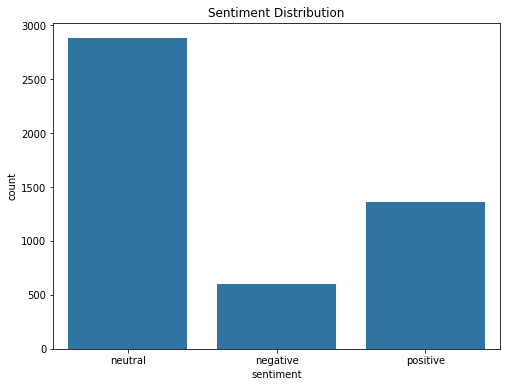

In [133]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=financial_data)
plt.title('Sentiment Distribution')
plt.savefig('sentiment_distribution.png')
plt.show()

### The text data is preprocessed by removing noise

In [134]:
sentiment_dict

{'neutral': 0, 'negative': 1, 'positive': 2}

In [135]:
# Word frequencies
financial_data['NewsHeadline'].str.split(expand=True).stack().value_counts()

.                4780
the              4712
,                4662
of               3202
in               2752
                 ... 
NASDAQ-listed       1
Malaysians          1
sponsors            1
Endowment           1
Midwest             1
Name: count, Length: 12971, dtype: int64

In [136]:
# Length statistics
financial_data['NewsHeadline'].str.len().describe()

count    4846.000000
mean      128.132068
std        56.526180
min         9.000000
25%        84.000000
50%       119.000000
75%       163.000000
max       315.000000
Name: NewsHeadline, dtype: float64

In [137]:
# Group by 'NewsHeadline' column
df = financial_data.groupby('NewsHeadline')

# Get count of each unique headline
headline_counts = df.size()

# Show headlines with multiple sentiment labels
conflicts = df['sentiment'].nunique()[lambda x: x > 1]

conflicts

NewsHeadline
TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sells stake in Morning Digital Design Oy Finnish IT company TJ Group Plc said on Friday 7 April that it had signed an agreement on selling its shares of Morning Digital Design Oy to Edita Oyj .    2
The Group 's business is balanced by its broad portfolio of sports and presence in all major markets .                                                                                                                                          2
Name: sentiment, dtype: int64

In [138]:
financial_data[financial_data['NewsHeadline'].str.contains(
    "TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sells stake"
)]

,sentiment,NewsHeadline,label
78,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,0
79,positive,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,2


In [139]:
financial_data[financial_data['NewsHeadline'].str.contains(
    "The Group 's business is balanced by its broad portfolio of sports and presence in all major markets ."
)]

,sentiment,NewsHeadline,label
788,positive,The Group 's business is balanced by its broad...,2
789,neutral,The Group 's business is balanced by its broad...,0


First sentence is neutral so droping the second occurance \
Second sentence is positive so droping the first occurance 

In [140]:
idx_to_drop = [79,789]
# Droping the text based on their sentiments
financial_data.drop(index=idx_to_drop, inplace=True,  errors='ignore')

# Verify the new shape
financial_data.shape

(4844, 3)

#### Spliting the data

In [141]:
import random

seed_val = 2022
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [142]:
# Split data into features and labels
headlines = financial_data.NewsHeadline.values
labels = financial_data.label.values

# Create train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    headlines, labels, test_size=0.20, random_state=2022, stratify=labels
)

In [143]:
X_train

array(['Operating profit improved by 27 % to EUR 579.8 mn from EUR 457.2 mn in 2006 .',
       'The Oxyview Pulse Oximeter is a common device to check patient blood-oxygen saturation level and pulse rate .',
       'The writing and publication of Lemmink+ñinen -¦ s history is a continuation of earlier collaboration between Antti Tuuri and the company .',
       ..., 'Currently Glaston employs approximately 1,500 persons .',
       "Danske Bank is Denmark 's largest bank with 3.5 million customers .",
       "Vaisala 's Present Weather Detector measures visibility up to 20 km , as well as precipitation type and intensity ."],
      shape=(3875,), dtype=object)

### Tokanization and Dataset Creation

In [144]:
# Initialize tokenizer
# Get the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Tokenize data
encoded_data_train = tokenizer.batch_encode_plus(
    X_train,
    return_tensors="pt",
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=150,
    truncation=True
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    return_tensors="pt",
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=150,
    truncation=True
)

In [145]:
type(encoded_data_train)

transformers.tokenization_utils_base.BatchEncoding

In [146]:
encoded_data_train

{'input_ids': tensor([[  101,  4082,  5618,  ...,     0,     0,     0],
        [  101,  1996, 23060,  ...,     0,     0,     0],
        [  101,  1996,  3015,  ...,     0,     0,     0],
        ...,
        [  101,  2747,  1043,  ...,     0,     0,     0],
        [  101, 18033,  3489,  ...,     0,     0,     0],
        [  101, 12436, 14268,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [147]:
# See what keys are available
print(encoded_data_train.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [148]:
# See the input IDs for the first encoded example
print(len(encoded_data_train['input_ids']))



3875


In [149]:
encoded_data_train['token_type_ids'][0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])

In [150]:
encoded_data_train['input_ids'][0]

tensor([  101,  4082,  5618,  5301,  2011,  2676,  1003,  2000,  7327,  2099,
         5401,  2683,  1012,  1022, 24098,  2013,  7327,  2099,  3429,  2581,
         1012,  1016, 24098,  1999,  2294,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [151]:
# Token IDs with its readable tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_data_train['input_ids'][0])
print(tokens)

['[CLS]', 'operating', 'profit', 'improved', 'by', '27', '%', 'to', 'eu', '##r', '57', '##9', '.', '8', 'mn', 'from', 'eu', '##r', '45', '##7', '.', '2', 'mn', 'in', '2006', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [152]:
# Create datasets
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

In [153]:
# Create DataLoaders
batch_size = 16

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=batch_size
)

### Model Setup

In [154]:
# # Set up GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Initialize model
# num_classes = len(sentiment_dict)  # Number of sentiment classes

# # model = AutoModelForSequenceClassification.from_pretrained(
# #     "bert-base-uncased",
# #     num_labels=num_classes,
# #     output_attentions=False,
# #     output_hidden_states=False,
# # )

# model = AutoModelForSequenceClassification.from_pretrained(
#     "ProsusAI/finbert", num_labels=num_classes
# )

# # Move model to device
# model.to(device)

# # Set up optimizer with weight decay and learning rate
# # optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

# # Set up learning rate scheduler
# epochs = 4
# total_steps = len(dataloader_train) * epochs
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=0,
#     num_training_steps=total_steps
# )

In [155]:
# 1. Implement Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        """
        Focal Loss implementation
        
        Args:
            alpha: Weight factor (default=1)
            gamma: Focusing parameter - higher values increase focus on hard examples (default=2)
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        # Standard cross entropy
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Get probabilities for the correct class
        pt = torch.exp(-ce_loss)
        
        # Apply focal weighting
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        return focal_loss.mean()

In [156]:
# 2. Enhanced training function with:
#    - Focal Loss
#    - Discriminative Learning Rates
#    - Dropout Adjustment
#    - Gradual Unfreezing
def enhanced_train(model, dataloader_train, dataloader_val, device, sentiment_dict, epochs=4):
    """
    Enhanced training function with advanced techniques
    
    Args:
        model: The FinBERT model
        dataloader_train: Training data loader
        dataloader_val: Validation data loader
        device: Computing device (CPU or GPU)
        sentiment_dict: Dictionary mapping sentiment labels to indices
        epochs: Number of training epochs
    
    Returns:
        Training statistics and the best model
    """
    print("\n======== Enhanced FinBERT Training ========")
    
    # Initialize focal loss
    criterion = FocalLoss(gamma=2.0)
    
    # Training stats
    training_stats = []
    best_f1 = 0
    
    # Start with most layers frozen
    # First freeze all parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze the classification head - always train this
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    for epoch in range(1, epochs + 1):
        print(f"\n======== Epoch {epoch} / {epochs} ========")
        
        # Gradual unfreezing - unfreeze more layers as training progresses
        if epoch == 1:
            # Only classification head is unfrozen (done above)
            pass
        elif epoch == 2:
            # Unfreeze the last encoder layer
            for param in model.bert.encoder.layer[-1].parameters():
                param.requires_grad = True
        elif epoch == 3:
            # Unfreeze the last 2 encoder layers
            for i in range(2):
                for param in model.bert.encoder.layer[-(i+1)].parameters():
                    param.requires_grad = True
        elif epoch == 4:
            # Unfreeze all layers
            for param in model.parameters():
                param.requires_grad = True
        
        # Apply discriminative learning rates
        # Lower layers get smaller learning rates, higher layers get larger rates
        param_groups = []
        
        # Embeddings - lowest learning rate
        if epoch >= 4:  # Only if we've unfrozen these layers
            param_groups.append({
                "params": model.bert.embeddings.parameters(),
                "lr": 1e-5
            })
        
        # Lower transformer layers - low learning rate
        if epoch >= 4:  # Only if we've unfrozen these layers
            param_groups.append({
                "params": model.bert.encoder.layer[:6].parameters(),
                "lr": 2e-5
            })
        
        # Middle transformer layers - medium learning rate
        if epoch >= 3:  # Only if we've unfrozen these layers
            param_groups.append({
                "params": model.bert.encoder.layer[6:10].parameters(),
                "lr": 3e-5
            })
        
        # Higher transformer layers - higher learning rate
        if epoch >= 2:  # Only if we've unfrozen these layers
            param_groups.append({
                "params": model.bert.encoder.layer[10:].parameters(),
                "lr": 4e-5
            })
        
        # Classification head - highest learning rate
        param_groups.append({
            "params": model.classifier.parameters(),
            "lr": 5e-5
        })
        
        # Set up optimizer with the parameter groups
        optimizer = torch.optim.AdamW(param_groups, eps=1e-8)
        
        # Learning rate scheduler
        total_steps = len(dataloader_train) * 1  # Just for this epoch
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )
        
        # Track variables for epoch
        model.train()
        loss_train_total = 0
        
        # Training loop
        progress_bar = tqdm(dataloader_train, desc='Training', leave=True)
        
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            
            # Get inputs
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
            }
            
            # Forward pass
            outputs = model(**inputs)
            logits = outputs.logits
            
            # Compute focal loss
            loss = criterion(logits, batch[2])
            
            loss_train_total += loss.item()
            
            # Backward pass
            loss.backward()
            
            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # Update parameters
            optimizer.step()
            scheduler.step()
            
            # Update progress bar
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})
        
        # Calculate average training loss
        loss_train_avg = loss_train_total / len(dataloader_train)
        print(f"Training loss: {loss_train_avg}")
        
        # Validation
        val_loss, predictions, true_vals = evaluate(dataloader_val, model, device, criterion)
        
        # Calculate metrics
        accuracy = accuracy_score(true_vals, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_vals, predictions, average='weighted')
        mcc = matthews_corrcoef(true_vals, predictions)
        
        print(f"Validation loss: {val_loss}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"MCC: {mcc:.4f}")
        
        # Track unfrozen parameters for reporting
        unfrozen_count = sum(p.requires_grad for p in model.parameters())
        total_params = sum(1 for _ in model.parameters())
        
        # Save stats for this epoch
        epoch_stats = {
            'epoch': epoch,
            'train_loss': loss_train_avg,
            'val_loss': val_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'unfrozen_params': f"{unfrozen_count}/{total_params}"
        }
        training_stats.append(epoch_stats)
        
        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_enhanced_finbert_model.pt')
            print(f"Best model saved with F1: {best_f1:.4f}")
    
    return training_stats, best_f1

In [157]:
def evaluate(dataloader_val, model, device, criterion=None):
    """
    Evaluate the model on validation data
    
    Args:
        dataloader_val: Validation data loader
        model: The model to evaluate
        device: Computing device
        criterion: Loss function (optional)
    
    Returns:
        Average validation loss, predictions, and true values
    """
    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
        }
        labels = batch[2]
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        logits = outputs.logits
        
        # Calculate loss
        if criterion is not None:
            loss = criterion(logits, labels)
        else:
            loss = F.cross_entropy(logits, labels)
            
        loss_val_total += loss.item()
        
        # Convert logits to predicted class indices
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = labels.cpu().numpy()
        
        predictions.append(preds)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total / len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    return loss_val_avg, predictions, true_vals

In [158]:
# Main function to initialize and train the enhanced model
def train_enhanced_finbert(X_train, X_val, y_train, y_val, sentiment_dict, epochs=4):
    """
    Initialize and train an enhanced FinBERT model
    
    Args:
        X_train, X_val: Training and validation text data
        y_train, y_val: Training and validation labels
        sentiment_dict: Dictionary of sentiment classes
        epochs: Number of training epochs
    
    Returns:
        Trained model and training statistics
    """
    # Set up GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize model with adjusted dropout
    config = BertConfig.from_pretrained("ProsusAI/finbert")
    config.hidden_dropout_prob = 0.3  # Increased from default (usually 0.1)
    config.attention_probs_dropout_prob = 0.3  # Increased from default
    config.num_labels = len(sentiment_dict)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert", 
        config=config
    )
    
    # Move model to device
    model.to(device)
    
    # Train with enhanced techniques
    training_stats, best_f1 = enhanced_train(
        model, 
        dataloader_train,  # Assume these are defined in the global scope
        dataloader_val,
        device,
        sentiment_dict,
        epochs=epochs
    )
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load('best_enhanced_finbert_model.pt'))
    
    return model, training_stats, device


# Example usage:
enhanced_model, training_stats_finbert,device  = train_enhanced_finbert(X_train, X_val, y_train, y_val, sentiment_dict)

# This function should be integrated into the main training pipeline, replacing the original training code
# The dataloader_train and dataloader_val should be passed from the existing code

Using device: cuda

======== Enhanced FinBERT Training ========

======== Epoch 1 / 4 ========


Training: 100%|██████████| 243/243 [00:14<00:00, 17.19it/s, training_loss=0.410]


Training loss: 0.479514812429746
Validation loss: 0.17252930296493357
Accuracy: 0.8731
Precision: 0.8851
Recall: 0.8731
F1 Score: 0.8750
MCC: 0.7853
Best model saved with F1: 0.8750

======== Epoch 2 / 4 ========


Training: 100%|██████████| 243/243 [00:16<00:00, 14.96it/s, training_loss=0.051]


Training loss: 0.1550855943588195
Validation loss: 0.14702319190455754
Accuracy: 0.8824
Precision: 0.8971
Recall: 0.8824
F1 Score: 0.8843
MCC: 0.8050
Best model saved with F1: 0.8843

======== Epoch 3 / 4 ========


Training: 100%|██████████| 243/243 [00:18<00:00, 12.98it/s, training_loss=0.066]


Training loss: 0.1463159140575018
Validation loss: 0.1393206885664678
Accuracy: 0.8782
Precision: 0.8943
Recall: 0.8782
F1 Score: 0.8803
MCC: 0.7989

======== Epoch 4 / 4 ========


Training: 100%|██████████| 243/243 [00:44<00:00,  5.49it/s, training_loss=0.181]


Training loss: 0.13228289972331544
Validation loss: 0.1392696710364496
Accuracy: 0.8772
Precision: 0.8912
Recall: 0.8772
F1 Score: 0.8792
MCC: 0.7947


### Model Evaluation and Visualization

In [159]:
training_stats_finbert

[{'epoch': 1,
  'train_loss': 0.479514812429746,
  'val_loss': 0.17252930296493357,
  'accuracy': 0.8730650154798761,
  'precision': 0.8850729940247262,
  'recall': 0.8730650154798761,
  'f1': 0.8749934951281281,
  'mcc': np.float64(0.7852634470919092),
  'unfrozen_params': '2/201'},
 {'epoch': 2,
  'train_loss': 0.1550855943588195,
  'val_loss': 0.14702319190455754,
  'accuracy': 0.8823529411764706,
  'precision': 0.8971477821719848,
  'recall': 0.8823529411764706,
  'f1': 0.8842850899922603,
  'mcc': np.float64(0.8049666772012929),
  'unfrozen_params': '18/201'},
 {'epoch': 3,
  'train_loss': 0.1463159140575018,
  'val_loss': 0.1393206885664678,
  'accuracy': 0.8782249742002064,
  'precision': 0.894256250224703,
  'recall': 0.8782249742002064,
  'f1': 0.8803257173102265,
  'mcc': np.float64(0.7988616357105262),
  'unfrozen_params': '34/201'},
 {'epoch': 4,
  'train_loss': 0.13228289972331544,
  'val_loss': 0.1392696710364496,
  'accuracy': 0.8771929824561403,
  'precision': 0.8911934

<Figure size 720x576 with 0 Axes>

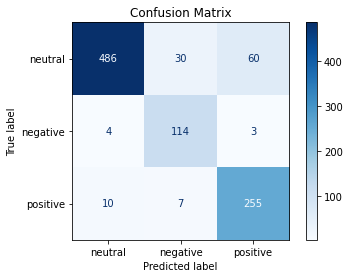

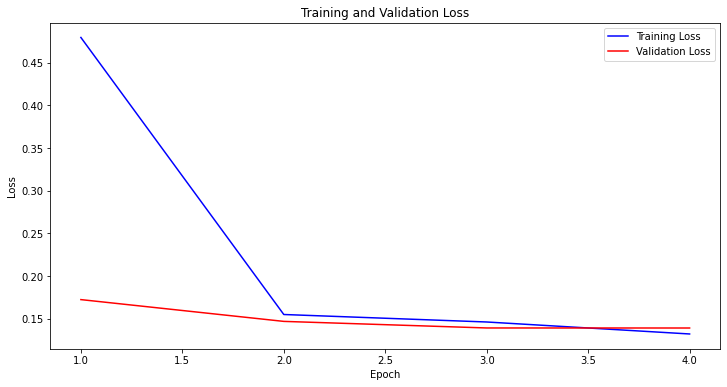

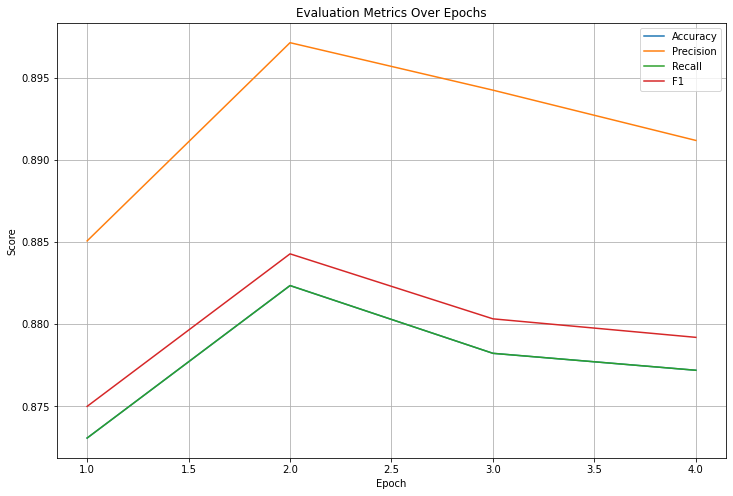

In [160]:
# Load best model for final evaluation
enhanced_model.load_state_dict(torch.load('best_enhanced_finbert_model.pt'))
val_loss, predictions, true_vals = evaluate(dataloader_val, enhanced_model, device)

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_vals, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=list(sentiment_dict.keys()))

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
# plt.savefig('confusion_matrix.png')
# plt.close()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(12, 6))
train_losses = [stat['train_loss'] for stat in training_stats_finbert]
val_losses = [stat['val_loss'] for stat in training_stats_finbert]
# epochs_range = range(1, epochs + 1)
epochs_range = [stat['epoch'] for stat in training_stats_finbert]

plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('training_validation_loss.png')
plt.show()

# Plot metrics over epochs
plt.figure(figsize=(12, 8))
metrics = ['accuracy', 'precision', 'recall', 'f1']
# metrics = ['accuracy']
for metric in metrics:
    values = [stat[metric] for stat in training_stats_finbert]
    plt.plot(epochs_range, values, label=metric.capitalize())

plt.title('Evaluation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
# plt.savefig('metrics_over_epochs.png')
plt.show()

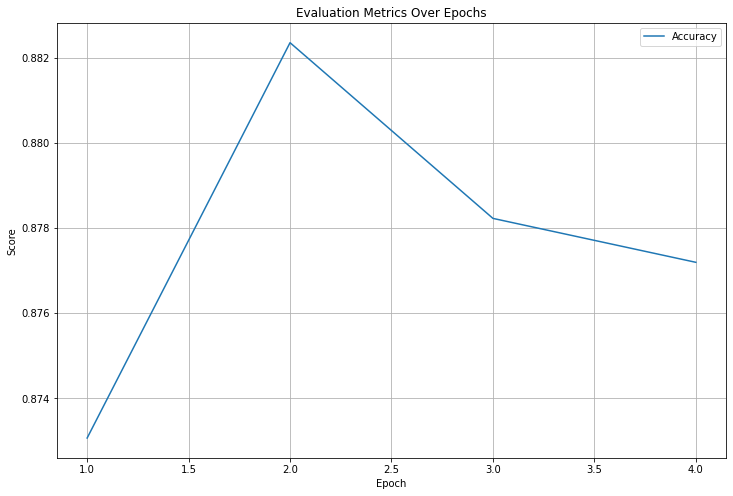

In [161]:
epochs_range = [stat['epoch'] for stat in training_stats_finbert]
epochs_range
metrics = ['accuracy']

# Plot metrics over epochs
plt.figure(figsize=(12, 8))
for metric in metrics:
    values = [stat[metric] for stat in training_stats_finbert]
    plt.plot(epochs_range, values, label=metric.capitalize())

plt.title('Evaluation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
# plt.savefig('metrics_over_epochs.png')
plt.show()

### Save Model and Performance Report

In [162]:
# Save model
model_path = "enhanced_finbert_model_final"
enhanced_model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")

# Create performance report
report = {
    'accuracy': accuracy_score(true_vals, predictions),
    'precision_recall_f1': precision_recall_fscore_support(true_vals, predictions, average='weighted'),
    'mcc': matthews_corrcoef(true_vals, predictions),
    'confusion_matrix': confusion_matrix(true_vals, predictions).tolist(),
    'training_history': training_stats_finbert
}

with open('enhanced_finbert_performance_report.json', 'w') as f:
    import json
    json.dump(report, f)

print("Performance report saved.")

Model saved to enhanced_finbert_model_final
Performance report saved.


### Inference Function for New Data

In [163]:
def predict_sentiment(text, model, tokenizer):
    # Prepare inputs
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_tensors='pt',
        max_length=150,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    
    # Get prediction
    enhanced_model.eval()
    with torch.no_grad():
        outputs = enhanced_model(input_ids=input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_class = np.argmax(probabilities)
    
    # Convert class index to sentiment
    reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
    predicted_sentiment = reverse_sentiment_dict[predicted_class]
    
    return {
        'sentiment': predicted_sentiment,
        'class_index': predicted_class,
        'probability': probabilities[predicted_class],
        'all_probabilities': {reverse_sentiment_dict[i]: prob for i, prob in enumerate(probabilities)}
    }

# Test inference
test_headline = "Company reports strong quarterly earnings exceeding analyst expectations"
prediction = predict_sentiment(test_headline, enhanced_model, tokenizer)
print(f"Headline: {test_headline}")
print(f"Predicted sentiment: {prediction['sentiment']}")
print(f"Confidence: {prediction['probability']:.4f}")

Headline: Company reports strong quarterly earnings exceeding analyst expectations
Predicted sentiment: positive
Confidence: 0.9039


### Baseline models

In [164]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer

In [165]:


# Define LSTM model class
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        if self.lstm.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
            
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [166]:
# Function to train and evaluate a model
def train_evaluate_model(model_name, tokenizer, model, dataloaders, num_epochs=4):
    print(f"\n======== Training {model_name} ========")
    
    # Setup optimizer and scheduler
#     optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)
    
    total_steps = len(dataloaders['train']) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    # Training loop
    training_stats = []
    best_f1 = 0
    
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch} / {num_epochs}")
        
        # Train
        model.train()
        loss_train_total = 0
        
        for batch in tqdm(dataloaders['train'], desc='Training'):
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            
            if model_name == 'LSTM':
                text, text_lengths, labels = batch
                outputs = model(text, text_lengths)
                loss = nn.CrossEntropyLoss()(outputs, labels)
            else:
                inputs = {
                    'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'labels': batch[2]
                }
                outputs = model(**inputs)
                loss = outputs.loss if hasattr(outputs, 'loss') else outputs[0]
            
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        loss_train_avg = loss_train_total / len(dataloaders['train'])
        
        # Evaluate
        model.eval()
        val_loss = 0
        predictions, true_vals = [], []
        
        for batch in dataloaders['val']:
            batch = tuple(b.to(device) for b in batch)
            
            with torch.no_grad():
                if model_name == 'LSTM':
                    text, text_lengths, labels = batch
                    outputs = model(text, text_lengths)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)
                else:
                    inputs = {
                        'input_ids': batch[0],
                        'attention_mask': batch[1],
                        'labels': batch[2]
                    }
                    outputs = model(**inputs)
                    loss = outputs.loss if hasattr(outputs, 'loss') else outputs[0]
                    logits = outputs.logits if hasattr(outputs, 'logits') else outputs[1]
                    preds = torch.argmax(logits, dim=1)
                
                val_loss += loss.item()
                
                preds = preds.detach().cpu().numpy()
                true_labels = batch[-1].cpu().numpy()
                
                predictions.append(preds)
                true_vals.append(true_labels)
        
        val_loss = val_loss / len(dataloaders['val'])
        predictions = np.concatenate(predictions)
        true_vals = np.concatenate(true_vals)
        
        # Calculate metrics
        accuracy = accuracy_score(true_vals, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(true_vals, predictions, average='weighted')
        mcc = matthews_corrcoef(true_vals, predictions)
        
        print(f"Train Loss: {loss_train_avg:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}")
        
        # Save stats
        epoch_stats = {
            'epoch': epoch,
            'model': model_name,
            'train_loss': loss_train_avg,
            'val_loss': val_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc
        }
        training_stats.append(epoch_stats)
        
        # Save best model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), f'best_{model_name.lower()}_model.pt')
    
    return training_stats, best_f1

In [167]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef
import numpy as np

def train_evaluate_naive_bayes(model_name, data, num_epochs=1):
    """
    Train and evaluate Naive Bayes using scikit-learn.
    
    Args:
        model_name (str): Name of the model ('NaiveBayes').
        data (dict): Data from prepare_data_for_models, with 'train': {'X': X_train_tfidf, 'y': y_train},
                     'val': {'X': X_val_tfidf, 'y': y_val}.
        num_epochs (int): Dummy parameter for consistency (Naive Bayes trains in one step).
    
    Returns:
        training_stats (list): List of dicts with metrics, mimicking train_evaluate_model.
        best_f1 (float): Best weighted F1 score.
    """
    print(f"\n======== Training {model_name} ========")
    
    # Extract data
    X_train_tfidf = data['train']['X']  # Sparse TF-IDF matrix
    y_train = data['train']['y']       # Labels (e.g., [0, 1, 2])
    X_val_tfidf = data['val']['X']
    y_val = data['val']['y']
    
    # Initialize model
    naiveBayes_model = MultinomialNB(alpha=1.0)
    
    # Train (single step, no epochs)
    print("Training Naive Bayes (single step)")
    naiveBayes_model.fit(X_train_tfidf, y_train)
    
    # Evaluate on validation set
    predictions = naiveBayes_model.predict(X_val_tfidf)
    true_vals = np.array(y_val)
    
    # Calculate metrics
    accuracy = accuracy_score(true_vals, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_vals, predictions, average='weighted')
    mcc = matthews_corrcoef(true_vals, predictions)
    
    print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}")
    
    # Create training_stats to match train_evaluate_model
    training_stats = [{
        'epoch': 1,  # Single step, treated as one epoch
        'model': model_name,
        'train_loss': 0.0,  # Naive Bayes doesn't compute loss, use 0
        'val_loss': 0.0,    # Same
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc
    }]
    
    # Save model (optional, using joblib for scikit-learn)
    from joblib import dump
    dump(naiveBayes_model, f'best_{model_name.lower()}_model.joblib')
    
    return training_stats, f1

In [168]:
# Prepare data for all models
def prepare_data_for_models():
    models_data = {}
    
    # BERT data (already prepared)
    models_data['FinBERT'] = {
        'train': dataloader_train,
        'val': dataloader_val
    }
    
    # DistilBERT data
    distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoded_data_train_distilbert = distilbert_tokenizer.batch_encode_plus(
        X_train, 
        return_tensors="pt",
        padding='max_length',
        max_length=150,
        truncation=True,
        return_attention_mask=True
    )
    encoded_data_val_distilbert = distilbert_tokenizer.batch_encode_plus(
        X_val,
        return_tensors="pt",
        padding='max_length',
        max_length=150,
        truncation=True,
        return_attention_mask=True
    )
    
    distilbert_dataset_train = TensorDataset(
        encoded_data_train_distilbert['input_ids'],
        encoded_data_train_distilbert['attention_mask'],
        torch.tensor(y_train)
    )
    distilbert_dataset_val = TensorDataset(
        encoded_data_val_distilbert['input_ids'],
        encoded_data_val_distilbert['attention_mask'],
        torch.tensor(y_val)
    )
    
    distilbert_dataloader_train = DataLoader(
        distilbert_dataset_train,
        sampler=RandomSampler(distilbert_dataset_train),
        batch_size=batch_size
    )
    distilbert_dataloader_val = DataLoader(
        distilbert_dataset_val,
        sampler=SequentialSampler(distilbert_dataset_val),
        batch_size=batch_size
    )
    
    models_data['DistilBERT'] = {
        'train': distilbert_dataloader_train,
        'val': distilbert_dataloader_val
    }
    

    
    # LSTM data (requires different processing)
    # Create vocabulary for LSTM
    from collections import Counter
    word_counts = Counter()
    for headline in X_train:
        word_counts.update(headline.split())
    
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, _ in word_counts.most_common(10000):  # Top 10000 words
        if word not in vocab:
            vocab[word] = len(vocab)
    
    # Function to convert text to indices
    def text_to_indices(text, vocab):
        return [vocab.get(word, vocab['<unk>']) for word in text.split()]
    
    # Process data for LSTM
    X_train_indices = [text_to_indices(text, vocab) for text in X_train]
    X_val_indices = [text_to_indices(text, vocab) for text in X_val]
    
    # Pad sequences
    from torch.nn.utils.rnn import pad_sequence
    
    def pad_sequences(sequences, pad_idx=0):
        lengths = torch.tensor([len(seq) for seq in sequences])
        padded_seqs = pad_sequence([torch.tensor(s) for s in sequences], batch_first=True, padding_value=pad_idx)
        return padded_seqs, lengths
    
    # Create DataLoaders for LSTM
    class LSTMDataset(torch.utils.data.Dataset):
        def __init__(self, texts, labels):
            self.texts = texts
            self.labels = labels
        
        def __len__(self):
            return len(self.labels)
        
        def __getitem__(self, idx):
            return torch.tensor(self.texts[idx]), self.labels[idx]
    
    lstm_dataset_train = LSTMDataset(X_train_indices, y_train)
    lstm_dataset_val = LSTMDataset(X_val_indices, y_val)
    
    def lstm_collate_fn(batch):
        texts, labels = zip(*batch)
        texts_padded, lengths = pad_sequences(texts)
        return texts_padded, lengths, torch.tensor(labels)
    
    lstm_dataloader_train = DataLoader(
        lstm_dataset_train,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lstm_collate_fn
    )
    
    lstm_dataloader_val = DataLoader(
        lstm_dataset_val,
        batch_size=batch_size,
        collate_fn=lstm_collate_fn
    )
    
    models_data['LSTM'] = {
        'train': lstm_dataloader_train,
        'val': lstm_dataloader_val,
        'vocab_size': len(vocab)
    }
    
    
    # Naive Bayes data (scikit-learn)
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', lowercase=True)
    X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit and transform training data
    X_val_tfidf = vectorizer.transform(X_val)  # Transform validation data
    
    models_data['NaiveBayes'] = {
        'train': {'X': X_train_tfidf, 'y': y_train},
        'val': {'X': X_val_tfidf, 'y': y_val},
        'vectorizer': vectorizer  # Store for test data or predictions
    }
    
    return models_data

In [169]:
# Train and evaluate all models
# Initialize model
num_classes = len(sentiment_dict)  # Number of sentiment classes

def compare_models():
    print("Preparing data for all models...")
    models_data = prepare_data_for_models()
    
    model_results = {}
    
    # FinBERT (already trained)
    # Load the best model
    # finbert_model = BertForSequenceClassification.from_pretrained(
    #     "bert-base-uncased",
    #     num_labels=len(sentiment_dict),
    #     output_attentions=False,
    #     output_hidden_states=False,
    # )
    finbert_model = AutoModelForSequenceClassification.from_pretrained(
        "ProsusAI/finbert", num_labels=num_classes
    )

    finbert_model.to(device)
    finbert_model.load_state_dict(torch.load('best_enhanced_finbert_model.pt'))
    
    # DistilBERT
    print("\nTraining DistilBERT...")
    
    distilbert_model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(sentiment_dict)
    )
    distilbert_model.to(device)
    
    distilbert_stats, distilbert_best_f1 = train_evaluate_model(
        'DistilBERT',
        None,
        distilbert_model,
        models_data['DistilBERT']
    )
    model_results['DistilBERT'] = distilbert_stats
    

    
    # LSTM
    print("\nTraining LSTM...")
    lstm_model = LSTMSentiment(
        vocab_size=models_data['LSTM']['vocab_size'],
        embedding_dim=100,
        hidden_dim=256,
        output_dim=len(sentiment_dict),
        n_layers=2,
        bidirectional=True,
        dropout=0.5,
        pad_idx=0
    )
    lstm_model.to(device)
    
    lstm_stats, lstm_best_f1 = train_evaluate_model(
        'LSTM',
        None,
        lstm_model,
        models_data['LSTM']
    )
    model_results['LSTM'] = lstm_stats
    
    # Naive Bayse
    print("\nTraining Naive Bayse...")

    nb_stats, nb_best_f1 = train_evaluate_naive_bayes(
        'NaiveBayes',
        models_data['NaiveBayes'],
        num_epochs=1
    )
    model_results['NaiveBayes'] = nb_stats
    
    return model_results

In [170]:
# Run model comparison
model_comparison_results = compare_models()

Preparing data for all models...

Training DistilBERT...

======== Training DistilBERT ========

Epoch 1 / 4


Training: 100%|██████████| 243/243 [00:22<00:00, 10.88it/s]


Train Loss: 0.5013, Val Loss: 0.4171
Accuracy: 0.8308, F1: 0.8281, MCC: 0.6951

Epoch 2 / 4


Training: 100%|██████████| 243/243 [00:22<00:00, 10.85it/s]


Train Loss: 0.2341, Val Loss: 0.4162
Accuracy: 0.8566, F1: 0.8560, MCC: 0.7385

Epoch 3 / 4


Training: 100%|██████████| 243/243 [00:22<00:00, 10.84it/s]


Train Loss: 0.1058, Val Loss: 0.6753
Accuracy: 0.8380, F1: 0.8403, MCC: 0.7210

Epoch 4 / 4


Training: 100%|██████████| 243/243 [00:22<00:00, 10.84it/s]


Train Loss: 0.0469, Val Loss: 0.7022
Accuracy: 0.8504, F1: 0.8503, MCC: 0.7287

Training LSTM...

======== Training LSTM ========

Epoch 1 / 4


Training:   0%|          | 0/243 [00:00<?, ?it/s]/tmp/ipykernel_1364028/2235395861.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs = pad_sequence([torch.tensor(s) for s in sequences], batch_first=True, padding_value=pad_idx)
Training: 100%|██████████| 243/243 [00:01<00:00, 136.36it/s]
/homes/n264s646/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.9751, Val Loss: 0.9080
Accuracy: 0.5944, F1: 0.4432, MCC: 0.0000

Epoch 2 / 4


Training:   0%|          | 0/243 [00:00<?, ?it/s]/tmp/ipykernel_1364028/2235395861.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs = pad_sequence([torch.tensor(s) for s in sequences], batch_first=True, padding_value=pad_idx)
Training: 100%|██████████| 243/243 [00:01<00:00, 136.51it/s]
/homes/n264s646/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.9064, Val Loss: 0.8928
Accuracy: 0.5944, F1: 0.4432, MCC: 0.0000

Epoch 3 / 4


Training:   0%|          | 0/243 [00:00<?, ?it/s]/tmp/ipykernel_1364028/2235395861.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs = pad_sequence([torch.tensor(s) for s in sequences], batch_first=True, padding_value=pad_idx)
Training: 100%|██████████| 243/243 [00:01<00:00, 136.16it/s]
/homes/n264s646/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.8871, Val Loss: 0.8868
Accuracy: 0.5944, F1: 0.4432, MCC: 0.0000

Epoch 4 / 4


Training:   0%|          | 0/243 [00:00<?, ?it/s]/tmp/ipykernel_1364028/2235395861.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_seqs = pad_sequence([torch.tensor(s) for s in sequences], batch_first=True, padding_value=pad_idx)
Training: 100%|██████████| 243/243 [00:01<00:00, 136.57it/s]
/homes/n264s646/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.8808, Val Loss: 0.8788
Accuracy: 0.5955, F1: 0.4456, MCC: 0.0402

Training Naive Bayse...

======== Training NaiveBayes ========
Training Naive Bayes (single step)
Accuracy: 0.6718, F1: 0.6101, MCC: 0.3337


In [171]:
model_comparison_results

{'DistilBERT': [{'epoch': 1,
   'model': 'DistilBERT',
   'train_loss': 0.5013129074632385,
   'val_loss': 0.4171493528563468,
   'accuracy': 0.8307533539731682,
   'precision': 0.8352820160114333,
   'recall': 0.8307533539731682,
   'f1': 0.8281043491129783,
   'mcc': np.float64(0.6950572752754106)},
  {'epoch': 2,
   'model': 'DistilBERT',
   'train_loss': 0.23408938056325593,
   'val_loss': 0.4162260595648015,
   'accuracy': 0.8565531475748194,
   'precision': 0.8557180822299748,
   'recall': 0.8565531475748194,
   'f1': 0.8560221694650704,
   'mcc': np.float64(0.7385039601654376)},
  {'epoch': 3,
   'model': 'DistilBERT',
   'train_loss': 0.10577735894286829,
   'val_loss': 0.6753225474175616,
   'accuracy': 0.8379772961816305,
   'precision': 0.8501279786371878,
   'recall': 0.8379772961816305,
   'f1': 0.8402915434705223,
   'mcc': np.float64(0.7210403529405902)},
  {'epoch': 4,
   'model': 'DistilBERT',
   'train_loss': 0.0468540267550306,
   'val_loss': 0.7021849551314457,
   '

In [172]:
training_stats_finbert

[{'epoch': 1,
  'train_loss': 0.479514812429746,
  'val_loss': 0.17252930296493357,
  'accuracy': 0.8730650154798761,
  'precision': 0.8850729940247262,
  'recall': 0.8730650154798761,
  'f1': 0.8749934951281281,
  'mcc': np.float64(0.7852634470919092),
  'unfrozen_params': '2/201'},
 {'epoch': 2,
  'train_loss': 0.1550855943588195,
  'val_loss': 0.14702319190455754,
  'accuracy': 0.8823529411764706,
  'precision': 0.8971477821719848,
  'recall': 0.8823529411764706,
  'f1': 0.8842850899922603,
  'mcc': np.float64(0.8049666772012929),
  'unfrozen_params': '18/201'},
 {'epoch': 3,
  'train_loss': 0.1463159140575018,
  'val_loss': 0.1393206885664678,
  'accuracy': 0.8782249742002064,
  'precision': 0.894256250224703,
  'recall': 0.8782249742002064,
  'f1': 0.8803257173102265,
  'mcc': np.float64(0.7988616357105262),
  'unfrozen_params': '34/201'},
 {'epoch': 4,
  'train_loss': 0.13228289972331544,
  'val_loss': 0.1392696710364496,
  'accuracy': 0.8771929824561403,
  'precision': 0.8911934

In [173]:
# final_stats['FinBERT_w_Enhance'] = training_stats_finbert[-1]
# final_stats

#### Importing the file where finbert model (without enhancement) report were saved 

In [174]:
import json

# Read the JSON file
with open('finbert_performance_report.json', 'r') as file:
    data = json.load(file)

# Extract the training history
training_stats_finbert_before = data['training_history']

training_stats_finbert_before

# # Print or use the extracted data
# print(json.dumps(training_stats_finbert, indent=2))



[{'epoch': 1,
  'train_loss': 0.5275704017821162,
  'val_loss': 0.4080071515235745,
  'accuracy': 0.826625386996904,
  'precision': 0.8291281340291112,
  'recall': 0.826625386996904,
  'f1': 0.8207880572616199,
  'mcc': 0.677497516552707},
 {'epoch': 2,
  'train_loss': 0.23980869452848477,
  'val_loss': 0.47432061003856973,
  'accuracy': 0.8452012383900929,
  'precision': 0.8651514698244837,
  'recall': 0.8452012383900929,
  'f1': 0.84830927178124,
  'mcc': 0.7427815649250399},
 {'epoch': 3,
  'train_loss': 0.09772289577064798,
  'val_loss': 0.5531935514118828,
  'accuracy': 0.8710010319917441,
  'precision': 0.872261243231512,
  'recall': 0.8710010319917441,
  'f1': 0.8714703092984452,
  'mcc': 0.7686178143687052},
 {'epoch': 4,
  'train_loss': 0.042731810832557116,
  'val_loss': 0.6105766992454921,
  'accuracy': 0.8730650154798761,
  'precision': 0.8737505090969683,
  'recall': 0.8730650154798761,
  'f1': 0.873341279320254,
  'mcc': 0.7715792299306767}]

In [175]:
#     # Add FinBERT without Enhancement stats
#     final_stats['FinBERT_wo_Enhance'] = training_stats_finbert_before[-1]
#     final_stats

In [176]:
# for model_name, stats in model_results.items():
#         final_stats[model_name] = stats[-1]  # Last epoch stats
        
# final_stats[model_name]

In [177]:
final_stats

{'DistilBERT': {'epoch': 4,
  'model': 'DistilBERT',
  'train_loss': 0.04389935812659929,
  'val_loss': 0.661061816062534,
  'accuracy': 0.8441692466460269,
  'precision': 0.8453123193954235,
  'recall': 0.8441692466460269,
  'f1': 0.8445102451453517,
  'mcc': np.float64(0.7188709282824195)},
 'LSTM': {'epoch': 4,
  'model': 'LSTM',
  'train_loss': 0.8871168611962118,
  'val_loss': 0.8820480977902647,
  'accuracy': 0.5944272445820433,
  'precision': 0.3533437491014004,
  'recall': 0.5944272445820433,
  'f1': 0.44322342120292163,
  'mcc': 0.0},
 'NaiveBayes': {'epoch': 1,
  'model': 'NaiveBayes',
  'train_loss': 0.0,
  'val_loss': 0.0,
  'accuracy': 0.6718266253869969,
  'precision': 0.6590020499166861,
  'recall': 0.6718266253869969,
  'f1': 0.61012255310973,
  'mcc': np.float64(0.3337447211615582)},
 'FinBERT_w_Enhance': {'epoch': 4,
  'train_loss': 0.13715505650565948,
  'val_loss': 0.14907851824384244,
  'accuracy': 0.8431372549019608,
  'precision': 0.8723286911417177,
  'recall': 

Final stats after addition:
 {'DistilBERT': {'epoch': 4, 'model': 'DistilBERT', 'train_loss': 0.0468540267550306, 'val_loss': 0.7021849551314457, 'accuracy': 0.8503611971104231, 'precision': 0.850181033718165, 'recall': 0.8503611971104231, 'f1': 0.8502670608365926, 'mcc': np.float64(0.7286555926192935)}, 'LSTM': {'epoch': 4, 'model': 'LSTM', 'train_loss': 0.8808335912080458, 'val_loss': 0.8788214873095028, 'accuracy': 0.5954592363261094, 'precision': 0.634410528021561, 'recall': 0.5954592363261094, 'f1': 0.44556690611327354, 'mcc': np.float64(0.040176881150432546)}, 'NaiveBayes': {'epoch': 1, 'model': 'NaiveBayes', 'train_loss': 0.0, 'val_loss': 0.0, 'accuracy': 0.6718266253869969, 'precision': 0.6590020499166861, 'recall': 0.6718266253869969, 'f1': 0.61012255310973, 'mcc': np.float64(0.3337447211615582)}, 'FinBERT_w_Enhance': {'epoch': 4, 'train_loss': 0.13228289972331544, 'val_loss': 0.1392696710364496, 'accuracy': 0.8771929824561403, 'precision': 0.8911934843407031, 'recall': 0.8771

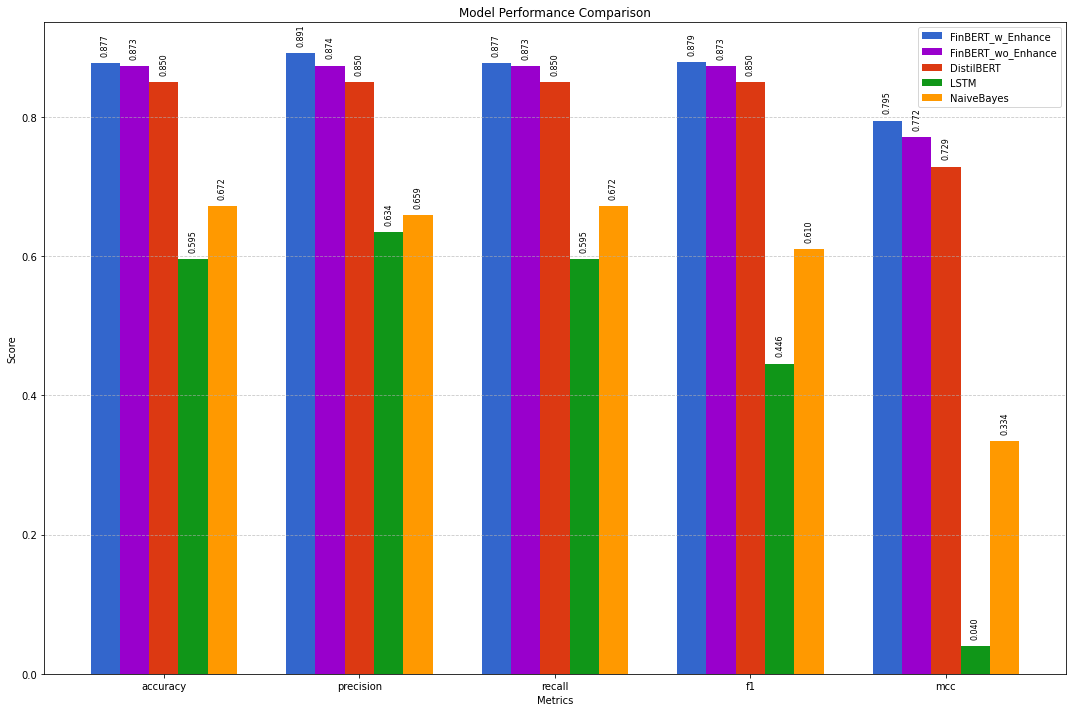


======== Model Comparison Results ========
             Model  accuracy  precision  recall     f1    mcc
        DistilBERT    0.8504     0.8502  0.8504 0.8503 0.7287
              LSTM    0.5955     0.6344  0.5955 0.4456 0.0402
        NaiveBayes    0.6718     0.6590  0.6718 0.6101 0.3337
 FinBERT_w_Enhance    0.8772     0.8912  0.8772 0.8792 0.7947
FinBERT_wo_Enhance    0.8731     0.8738  0.8731 0.8733 0.7716


In [178]:
def visualize_model_comparison(model_results):
    # Get final epoch stats for each model
    final_stats = {}
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
    
    for model_name, stats in model_results.items():
        final_stats[model_name] = stats[-1]  # Last epoch stats
    
    # Add FinBERT with Enhancement stats
    final_stats['FinBERT_w_Enhance'] = training_stats_finbert[-1]
    
    # Add FinBERT without Enhancement stats
    final_stats['FinBERT_wo_Enhance'] = training_stats_finbert_before[-1]
    
    print("Final stats after addition:\n", final_stats)
    
    # Create bar chart comparison
    plt.figure(figsize=(15, 10))
    
    # Create grouped bar chart for each metric
    x = np.arange(len(metrics))
    width = 0.15
    models = ['FinBERT_w_Enhance', 'FinBERT_wo_Enhance', 'DistilBERT', 'LSTM', 'NaiveBayes']
    colors = ['#3366cc', '#9900cc', '#dc3912', '#109618', '#ff9900']
    
    # Generate offsets dynamically based on number of models
    offsets = np.linspace(-width*2, width*2, len(models))
    
    for i, model in enumerate(models):
        values = [final_stats[model][metric] for metric in metrics]
        print(f"Values for {model}:", values)
        plt.bar(x + offsets[i], values, width, label=model, color=colors[i])
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of bars
    for i, model in enumerate(models):
        values = [final_stats[model][metric] for metric in metrics]
        for j, v in enumerate(values):
            plt.text(x[j] + offsets[i], v + 0.01, f'{v:.3f}', 
                    ha='center', va='bottom', fontsize=8, rotation=90)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    
    # Create and save results table
    results_table = pd.DataFrame.from_dict(final_stats, orient='index')[metrics]
    results_table.reset_index(inplace=True)
    results_table.rename(columns={'index': 'Model'}, inplace=True)
    results_table.to_csv('model_comparison_results.csv', index=False)
    
    print("\n======== Model Comparison Results ========")
    print(results_table.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    return results_table

# Visualize comparison results
comparison_results = visualize_model_comparison(model_comparison_results)